In [1]:
import sys
sys.path.append("models/")
from setup import out_dir, data_dir, image_dir, model_dir, streetview_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from dataloader import image_loader, load_demo
from autoencoder import Autoencoder
from M1_util_train_test import load_model, train, test, AverageMeter
from util_model import my_loss
from exp_version import get_hp_from_version_code

torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [21]:
from setup import model_dir, image_dir, out_dir, data_dir
from util_model import parse_args

zoomlevel = 'zoom15'
latent_dim = str(16*2)
image_size = str(64)
im_norm = '2'
model_run_date = "2210gan-0"
model_type = 'dcgan'
loss_func = 'cosh'
model_class = 'vae'

args = parse_args(s=['--zoomlevel', zoomlevel, '--latent_dim', latent_dim, '--image_size', image_size, \
                   '--im_norm', im_norm, '--model_run_date', model_run_date, '--model_type', model_type, \
                    '--loss_func', loss_func, '--model_class', model_class])

from util_model import dcgan_config, load_model

config = dcgan_config(args)

encoder = load_model('dcgan', 'Discriminator', config)
decoder = load_model('dcgan', 'Generator', config)

config['encoder'] = encoder
config['decoder'] = decoder

model = load_model('vae','VAE', config)
model.to(device)
model.train();

# Check one model exists for this config
import glob
import torch

if loss_func == 'cosh':
    model_path = glob.glob(model_dir+"cosh/AE_"+zoomlevel+"_"+str(latent_dim)+"_"+str(image_size)+
                       "_"+str(int(im_norm))+"_"+str(model_run_date)+"_*.pt")
else:
    model_path = glob.glob(model_dir+"AE_"+zoomlevel+"_"+str(latent_dim)+"_"+str(image_size)+
                       "_"+str(int(im_norm))+"_"+str(model_run_date)+"_*.pt")

if len(model_path) == 1:
    saved = torch.load(model_path[0])
    print(model_path[0], "loaded.")
else:
    print("Error. More than one model or no model exists.")
    print(model_path)
    print(model_dir+"AE_"+zoomlevel+"_"+str(latent_dim)+"_"+str(image_size)+
                       "_"+str(int(im_norm))+"_"+str(model_run_date)+"_*.pt")

model.load_state_dict(saved['model_state_dict']);
model.eval();

In [22]:
model_name = datetime.now().strftime("%m%d-%H%M")

run_config = config['run_config']
optim_config = config['optim_config']
data_config = config['data_config']
model_config = config['model_config']

# TensorBoard SummaryWriter
# writer = SummaryWriter(model_name) if run_config['tensorboard'] else None

# set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [10]:
# MNIST
import torchvision.transforms as transforms

def setup_data_loaders(batch_size=optim_config['batch_size'], use_cuda=True):
    root = './data'
    download = False
    trans = transforms.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

from pyro.contrib.examples.util import MNIST
train_loader, test_loader = setup_data_loaders()

In [6]:
# CelebA
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.datasets import CelebA

# train_set = datasets.CelebA(root="./", split="Train", download=True, transform=transforms.ToTensor())
# test_set = datasets.CelebA(root="./", split="Test", download=True, transform=transforms.ToTensor())

transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.CenterCrop(148),
                                              transforms.Resize(data_config['image_size']),
                                              transforms.ToTensor(),])
        
train_dataset = CelebA(
    "./",
    split='train',
    transform=transforms,
    download=False,
)

test_dataset = CelebA(
    "./",
    split='test',
    transform=transforms,
    download=False,
)

train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=optim_config['batch_size'],
            num_workers=8,
            shuffle=True,
            pin_memory=True,
        )

test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=optim_config['batch_size'],
            num_workers=8,
            shuffle=True,
            pin_memory=True,
        )

In [6]:
# Satellite
train_loader, test_loader = image_loader(image_dir+args.zoomlevel+"/", data_dir, optim_config['batch_size'], 
         run_config['num_workers'], 
         data_config['image_size'], 
         data_version=args.data_version, 
         sampling=args.sampling, 
         recalculate_normalize=False,
         augment=False,
         norm=args.im_norm)

28278 images in dataset
3142 images in dataset


In [6]:
# Streetview
model_run_date = '2209strt'
sampling = 'stratified'
data_version = '1571'


train_loader, test_loader = image_loader(streetview_dir, data_dir, 
                                         optim_config['batch_size'], 
                                         run_config['num_workers'], 
                                         data_config['image_size'], 
                                         data_version=data_version, 
                                         sampling=sampling, 
                                         recalculate_normalize=False,
                                         image_type='jpg')

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=optim_config['base_lr'])
criterion = model.loss_function
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

In [24]:
train_elbo = []
test_elbo = []
ref1 = 0
ref2 = 0


In [25]:
# training loop
start_epoch = 0
train_flag = False

for epoch in range(start_epoch, start_epoch+optim_config['epochs']):
    # initialize loss accumulator
    train_loss = 0.0
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for step, (image_list, data) in enumerate(train_loader):
#     for data, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        data = data.to(device)

        optimizer.zero_grad()
        
        # do ELBO gradient and accumulate loss
        x_, mu, log_var = model.forward(data)
        loss = criterion(x_, data, mu, log_var)#, len(data)/len(train_loader.dataset))
        
        train_loss += loss['loss'].item()
        
        loss['loss'].backward()

        optimizer.step()
        
    scheduler.step()
    # report training diagnostics
    
    train_loss /= len(train_loader)
    train_elbo.append(train_loss)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, train_loss))

    if epoch % 5 == 0:
        # initialize loss accumulator
        test_loss = 0.0
        test_recon = 0.0
        test_kld = 0.0
        
        # compute the loss over the entire test set
        for step, (image_list, data) in enumerate(test_loader):
#         for data,_ in test_loader:
            # if on GPU put mini-batch into CUDA memory
            data = data.to(device)
            # compute ELBO estimate and accumulate loss
            x_, mu, log_var = model.forward(data)
            loss = criterion(x_, data, mu, log_var)#, len(data)/len(train_loader.dataset))

            test_loss += loss['loss'].item()
            test_recon += loss['Reconstruction_Loss'].item()
            test_kld += loss['KLD'].item()
  
        # report test diagnostics
        test_loss /= len(test_loader)
        test_recon = test_recon / len(test_loader)/64/64/3
        test_kld /= len(test_loader)
        
        test_elbo.append(test_loss)
        print("[epoch %03d]  average test loss: %.4f" % (epoch, test_loss))
        
        print("recon loss:", test_recon, "KLD:", test_kld)
        
        
        if epoch > 30:
            if (np.abs(train_loss - ref1)/ref1<0.001) & (np.abs(train_loss - ref2)/ref2<0.001):
                print("Early stopping at epoch", epoch)
                train_flag = True
                break
            if (ref1 < train_loss) & (ref1 < ref2):
                print("Diverging. stop.")
                break
            if train_loss < best:
                best = train_loss
                best_epoch = epoch
                best_recon = test_recon
                best_kld = test_kld
        else:
            best = train_loss
            best_epoch = epoch
            best_recon = test_recon
            best_kld = test_kld

        ref2 = ref1
        ref1 = train_loss

        if (config['run_config']['save']) & (best_epoch==epoch):
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer,
                'config': config},
                model_dir+"VAE_"+args.zoomlevel+"_"+str(model_config['latent_dim']//2)+"_"+\
                  str(args.image_size)+"_"+str(int(args.im_norm))+"_"+str(args.model_run_date)+\
                  "_"+args.loss_func+"_"+str(epoch)+".pt")

files = glob.glob(model_dir+"VAE_"+args.zoomlevel+"_"+str(model_config['latent_dim']//2)+"_"+\
                      str(args.image_size)+"_"+str(int(args.im_norm))+"_"+str(args.model_run_date)+\
                      "_"+args.loss_func+"_*.pt")

if config['run_config']['save']:
    for f in files:
        e = int(f.split("_")[-1].split(".")[0])
        if e != best_epoch:
            os.remove(f)

with open(out_dir+"VAE.csv", "a") as f:
    f.write("%s,%s,%d,%d,%d,%.2E,%.2E,%d,%.4f,%.4f,%.4f,%d,%s\n" % \
            (args.model_run_date, args.zoomlevel, model_config['latent_dim']//2, args.image_size, args.im_norm, 
             args.base_lr, args.weight_decay, best_epoch, best, best_recon, best_kld, train_flag, args.loss_func))

[epoch 000]  average training loss: 1387432967910.2485
[epoch 000]  average test loss: 642.9592
recon loss: 0.04328767160574595 KLD: 111.04029510498047
[epoch 001]  average training loss: 600.8237
[epoch 002]  average training loss: 584.0374
[epoch 003]  average training loss: 579.7345
[epoch 004]  average training loss: 575.7459
[epoch 005]  average training loss: 583.4954
[epoch 005]  average test loss: 602.2746
recon loss: 0.041212457716465 KLD: 95.85591415405274
[epoch 006]  average training loss: 578.8165
[epoch 007]  average training loss: 568.5590
[epoch 008]  average training loss: 567.1774
[epoch 009]  average training loss: 562.8587
[epoch 010]  average training loss: 563.5109
[epoch 010]  average test loss: 581.0537
recon loss: 0.040301056901613876 KLD: 85.83431159973145
[epoch 011]  average training loss: 560.8772
[epoch 012]  average training loss: 559.8887
[epoch 013]  average training loss: 560.3804
[epoch 014]  average training loss: 558.9139
[epoch 015]  average traini

[epoch 127]  average training loss: 471.5752
[epoch 128]  average training loss: 471.2924
[epoch 129]  average training loss: 471.3540
[epoch 130]  average training loss: 471.2469
[epoch 130]  average test loss: 501.6831
recon loss: 0.03864128366112709 KLD: 26.858963279724122
[epoch 131]  average training loss: 471.0780
[epoch 132]  average training loss: 471.0904
[epoch 133]  average training loss: 470.9775
[epoch 134]  average training loss: 470.8607
[epoch 135]  average training loss: 470.8598
[epoch 135]  average test loss: 501.1669
recon loss: 0.03863153725862503 KLD: 26.4626118850708
[epoch 136]  average training loss: 470.5857
[epoch 137]  average training loss: 470.5340
[epoch 138]  average training loss: 470.5724
[epoch 139]  average training loss: 470.3687
[epoch 140]  average training loss: 470.2984
[epoch 140]  average test loss: 500.9166
recon loss: 0.0386445178091526 KLD: 26.052727851867676
[epoch 141]  average training loss: 470.1236
[epoch 142]  average training loss: 4

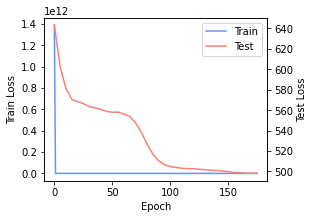

In [26]:
fig, ax = plt.subplots(1, figsize=(4,3))
ln1 = ax.plot(train_elbo, label='Train', color='cornflowerblue')
ax2 = ax.twinx()
ln2 = ax2.plot(np.arange(0, epoch+1, 5), test_elbo, label='Test', color='salmon')

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_xlabel("Epoch")
ax.set_ylabel("Train Loss")
ax2.set_ylabel("Test Loss")
# fig.savefig(out_dir+"training_plots/"+model_type+"_"+zoomlevel+"_"+str(latent_dim)+"_"+
#                 model_save_variable_names[y]+"_"+model_run_date+".png", bbox_inches='tight')
plt.show()


In [39]:
if zoomlevel == 'zoom13':
    mean = [0.3733, 0.3991, 0.3711]
    std = [0.2173, 0.2055, 0.2143]
elif zoomlevel == 'zoom15':
    mean = [0.3816, 0.4169, 0.3868]
    std = [0.1960, 0.1848, 0.2052]


In [27]:
for step, (image_list, data) in enumerate(test_loader):
    data = data.to(device)
    break

In [28]:
recon_imgs = model.reconstruct_img(data)

In [14]:
import util_image

In [29]:
recon_imgs = util_image.inverse_transform(recon_imgs, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])

In [27]:
recon_imgs.shape

torch.Size([64, 3, 64, 64])

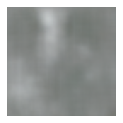

In [30]:
img_index = 8

fig, ax = plt.subplots(figsize=(2.5,2))

ax.imshow(recon_imgs[img_index,:,:,:].permute(1,2,0).detach().cpu().numpy())
ax.axis('off');

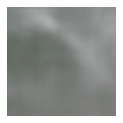

In [31]:
img_index = 15
fig, ax = plt.subplots(figsize=(2.5,2))

ax.imshow(recon_imgs[img_index,:,:,:].permute(1,2,0).detach().cpu().numpy())
ax.axis('off');

In [32]:
n = 64
z = torch.randn(64, model_config['latent_dim']//2).to(device)
sample_img = model.decode(z)

In [19]:
import torchvision.utils as vutils

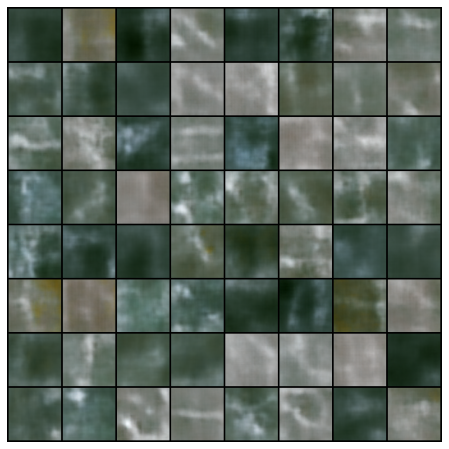

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(vutils.make_grid(sample_img.detach().cpu(), normalize=True).permute(1,2,0))
ax.axis('off');